# Step 1: Import Necessary Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import Counter
import albumentations as A
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Step 2: Define Dataset Paths

In [2]:
# Paths to the training and testing directories
data_dir_train = pathlib.Path("/kaggle/input/train-and-test-data/Train")  
data_dir_test = pathlib.Path("/kaggle/input/train-and-test-data/Test")    

# Count the number of images in train and test directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))

# Display the counts
print(f"Train images: {image_count_train}, Test images: {image_count_test}")


Train images: 2239, Test images: 118


# Step 3: Load Dataset

### Set Parameters

In [3]:
batch_size = 32
img_height = 180
img_width = 180


### Create Train and Validation Datasets

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.
Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Optimize Input Pipelines

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Step 4: Visualize Samples

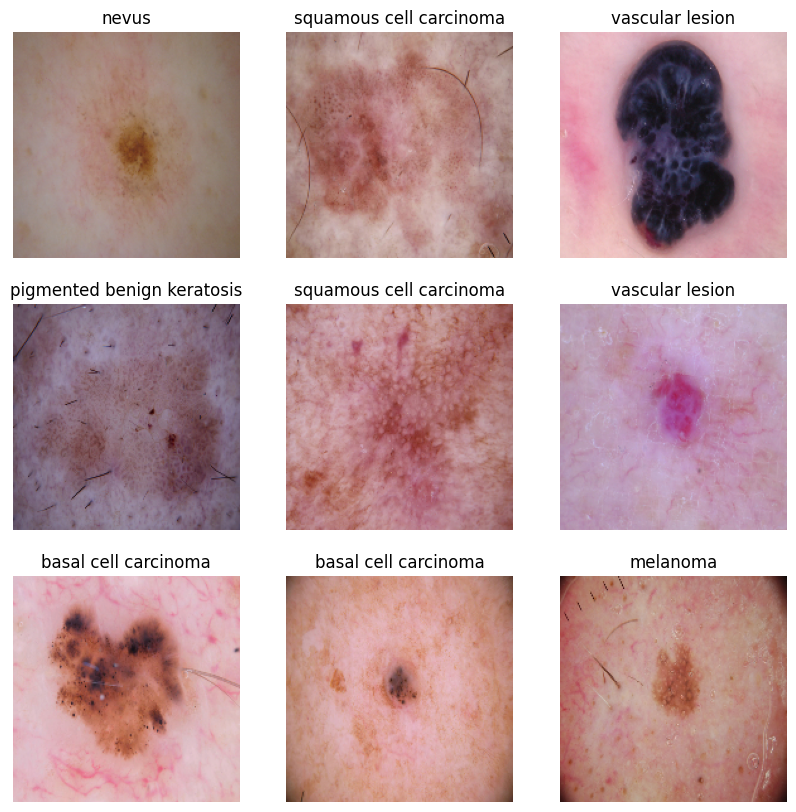

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


# Step 5: Create the Model Architecture

### Data Augmentation Layer

In [10]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


### Build the CNN Model

In [13]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


# Step 6: Compile the Model

In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)



# Step 7: Train the Model

### Train for 20 epochs (adjust based on overfitting/underfitting).

In [15]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.1736 - loss: 2.1694 - val_accuracy: 0.3512 - val_loss: 1.8842
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2849 - loss: 1.9426 - val_accuracy: 0.2998 - val_loss: 1.9002
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.3053 - loss: 1.8696 - val_accuracy: 0.4228 - val_loss: 1.6262
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4135 - loss: 1.6616 - val_accuracy: 0.4877 - val_loss: 1.5115
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4451 - loss: 1.5839 - val_accuracy: 0.4877 - val_loss: 1.4720
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4486 - loss: 1.5852 - val_accuracy: 0.4631 - val_loss: 1.5544
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4741 - loss: 1.4783 - val_accuracy: 0.4877 - val_loss: 1.5240
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4561 - loss: 1.5471 - val_accuracy: 0.5280 - val_loss:

## Findings After Model Fit

### Training vs. Validation Performance:



* Training accuracy steadily improves, reaching 55.56% at epoch 20.
* Validation accuracy fluctuates but eventually aligns close to training accuracy (54.14% at epoch 20), suggesting reasonable consistency.
* Training loss decreases consistently, but validation loss doesn't show as much stability, with fluctuations indicating overfitting tendencies in certain epochs.



* **Slight Overfitting**: The model shows mild overfitting as training loss continues to decrease while validation loss fluctuates and remains higher, especially during certain epochs.

* **Moderate Generalization Gap**: Training accuracy (55.56%) is slightly higher than validation accuracy (54.14%), indicating inconsistent generalization without severe overfitting.

* **Signs of Underfitting**: Relatively low overall accuracy and the plateau in performance after epoch 15 suggest that the model struggles to learn all patterns effectively.

* **Validation Performance Fluctuations**: Significant fluctuations in validation loss and accuracy (e.g., during epochs 6–10 and 17–18) hint at instability in model generalization.

# Step 8: Visualize Training Results

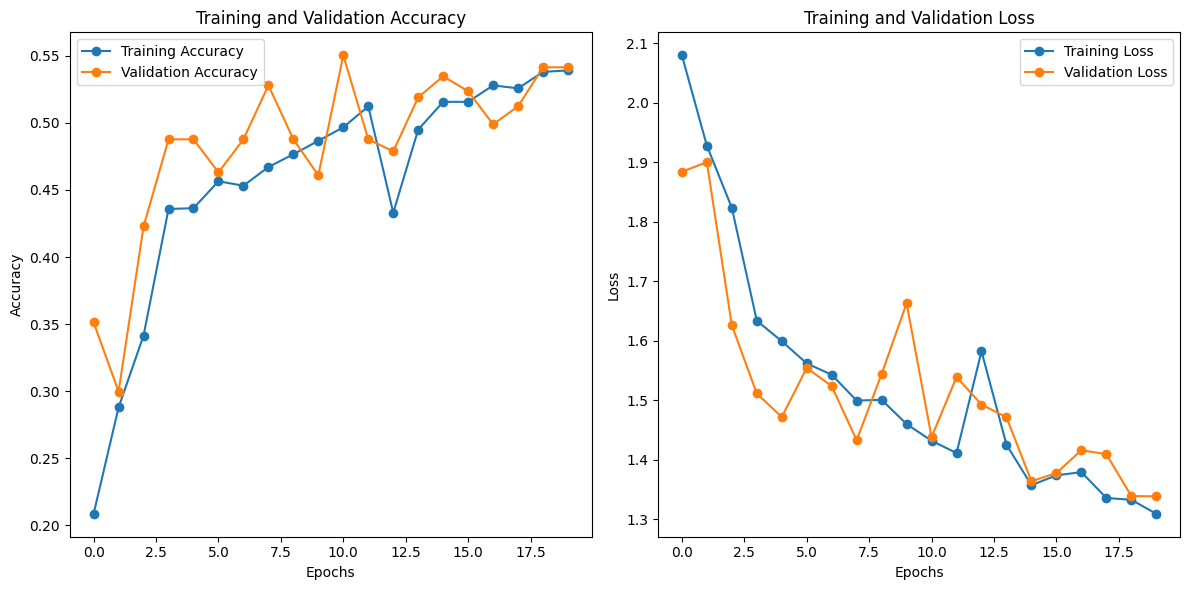

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(len(acc))  # Generate the range based on the number of epochs

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Step 9: Addressing and handling Class Imbalance

### Check Class Distribution

In [20]:
# Convert labels to a list of Python-native integers
all_labels = [int(label.numpy()) for _, label in train_ds.unbatch()]
# Use Counter to check the class distribution
print("Class distribution:", Counter(all_labels))


Class distribution: Counter({5: 370, 3: 352, 1: 309, 4: 277, 7: 142, 8: 115, 0: 92, 2: 77, 6: 58})


## Handling class imbalances

### Augment Using Augmentor

In [21]:
# Path to the read-only training dataset
path_to_training_dataset = "/kaggle/input/train-and-test-data/Train"

# Path to the writable output directory
output_path = "/kaggle/working/augmented_data"
os.makedirs(output_path, exist_ok=True)

# Augmentation pipeline using Albumentations
augmentation_pipeline = A.Compose([
    A.Rotate(limit=10, p=0.7),  # Rotate by ±10 degrees
    A.HorizontalFlip(p=0.5),    # Random horizontal flip
    A.RandomBrightnessContrast(p=0.5)  # Random brightness/contrast adjustment
])

# Process each class directory
for class_dir in os.listdir(path_to_training_dataset):
    class_path = os.path.join(path_to_training_dataset, class_dir)
    augmented_dir = os.path.join(output_path, f"{class_dir}_augmented")
    os.makedirs(augmented_dir, exist_ok=True)

    # Loop through all images in the class directory
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Load the image
        image = np.array(Image.open(img_path))

        # Apply augmentation and save the augmented image
        for i in range(5):  # Generate 5 augmented samples per original image
            augmented = augmentation_pipeline(image=image)
            augmented_image = Image.fromarray(augmented['image'])
            augmented_image.save(os.path.join(augmented_dir, f"{img_name.split('.')[0]}_aug_{i}.png"))


/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


## Model Architecture Summary After Addressing and handling Class Imbalance

In [22]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), 
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 classes, so output layer has 9 units
])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,829,513 (18.42 MB)

 Trainable params: 4,829,513 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Step 10: Model Building & training on the rectified class imbalance data

In [31]:
# Updated data preparation with separate validation data
train_data_dir = "/kaggle/working/augmented_data"  
img_height, img_width = 150, 150  # Image dimensions for resizing

# Define separate training and validation splits
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2  # 20% of data for validation
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset="training",  
    shuffle=True
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='categorical',
    subset="validation",  
    shuffle=False
)

# Steps per epoch calculations
train_steps = train_generator.samples // train_generator.batch_size
val_steps = validation_generator.samples // validation_generator.batch_size

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=val_steps
)


Found 8956 images belonging to 9 classes.
Found 2239 images belonging to 9 classes.
Epoch 1/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.4636 - loss: 1.5323 - val_accuracy: 0.4375 - val_loss: 1.5651
Epoch 2/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.7188 - loss: 0.9105 - val_accuracy: 0.6129 - val_loss: 1.5112
Epoch 3/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 588s 2s/step - accuracy: 0.5169 - loss: 1.3776 - val_accuracy: 0.4493 - val_loss: 1.6133
Epoch 4/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.5625 - loss: 1.4352 - val_accuracy: 0.6129 - val_loss: 1.6153
Epoch 5/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 591s 2s/step - accuracy: 0.5415 - loss: 1.2928 - val_accuracy: 0.4375 - val_loss: 1.7458
Epoch 6/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step - accuracy: 0.3125 - loss: 1.5537 - val_accuracy: 0.6774 - val_loss: 1.7876
Epoch 7/30
279/279 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - accuracy: 0.5608 - loss: 1.2223 - val_accuracy: 0.4583 - val_loss: 1.6741
Epoch 8/30

# Step 11: Findings and Observations After Model Training

The training process successfully completed for 30 epochs, with the following key outcomes observed:

1. **Training Progress**:
    * The training accuracy improved consistently over the epochs, starting at **46.36%** in Epoch 1 and reaching a peak of **84.38%** by Epoch 30.
    * Similarly, the training loss reduced from **1.53** to **0.50**, indicating the model's capacity to fit the training data effectively.

2. **Validation Performance**:
    * The validation accuracy varied, starting at **43.75%** and stabilizing around **67.74%** towards the end, showing notable improvement across the epochs.
    * However, the validation loss fluctuated significantly, peaking at **4.87** and ending at **4.19**, suggesting possible overfitting of the model to the training data.
3. **Challenges Noted**:
    * Despite consistent training progress, the fluctuating validation loss indicates that the model may require further regularization or early stopping to prevent overfitting.
    * Validation accuracy improvement, although evident, lagged behind the training accuracy, hinting at limited generalization.
4. **Positive Indicators**:
    * The model exhibits good potential, achieving over** 84% accuracy** on the training set and around **67% accuracy** on the validation set.
    * The high training accuracy suggests the model has learned the patterns in the training data well.